In [1]:
%matplotlib inline
from collections import Counter, OrderedDict, defaultdict
import copy
import glob
from itertools import izip
import itertools
import os
import subprocess
import tempfile

from IPython.core.display import HTML, Image
import itertools
import pandas as pd
from matplotlib import gridspec
from matplotlib import pyplot
import matplotlib as mpl
from matplotlib_venn import venn2, venn3
import numpy as np
import scipy
import seaborn as sns

from clipper.src import CLIP_analysis
from clipper.src import get_genomic_regions
import flotilla
from gscripts import GO
from gscripts.general import dataviz
from gscripts.general import parsers
from gscripts.general import region_helpers
from gscripts.rnaseq.helpers import counts_to_rpkm

img_dir = "/home/gpratt/Dropbox/cryptic_splicing/data/mouse_data/"

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
av_resequencing = parsers.rnaseq_metrics("/home/gpratt/projects/mov10/analysis/mov10_v1/")

In [3]:
av_resequencing_filtered = av_resequencing[[ "Input Reads",
                            #"Reads After Triming",
                            "Uniquely Mapped Reads",
                            "Uniquely mapped reads %",
                            ]]

HTML(av_resequencing_filtered.to_html(formatters={"Input Reads" : parsers.commas,
                                     "Reads After Triming" : parsers.commas,
                                     "Reads after Quality Filtering" : parsers.commas,
                                     "Uniquely Mapped Reads" : parsers.commas,
                                     } ))

,Input Reads,Uniquely Mapped Reads,Uniquely mapped reads %
DECaf_710_CAGATC_L002_R1,"33,705,559","25,522,861",84.64%
DECaf_718_CTTGTA_L002_R1,"29,762,206","22,047,530",83.85%
F_710_CGATGT_L002_R1,"22,273,129","16,363,977",84.12%
F_714_ATCACG_L001_R1,"33,796,220","3,458,938",79.55%
KAMOV_714_TAGCTT_L001_R1,"20,058,431","12,715,581",84.46%
KAMOV_718_GGCTAC_L001_R1,"8,338,875","6,049,867",84.52%
RIP_DECaf_710_GTCCGC_L002_R1,"13,581,397","3,747,060",81.69%
RIP_DECaf_718_GTGAAA_L002_R1,"10,782,542","6,788,230",85.94%
RIP_F_710_AGTCAA_L002_R1,"12,502,548","1,560,336",68.58%
RIP_F_718_AGTTCC_L002_R1,"12,410,921","295,365",60.80%


In [43]:
#RBP, mutation, ip/input, knockdown
data_organization = {
    
"DECaf_710_CAGATC_L002_R1": ("Caf1z", "DE", "input", "710", "none"),
"DECaf_718_CTTGTA_L002_R1": ("Caf1z", "DE", "input", "718","none"),
"F_710_CGATGT_L002_R1":  ("FLAG", "WT", "input", "710","Caf1z"),
"F_714_ATCACG_L001_R1":  ("FLAG", "WT", "input", "714","none"),
"KAMOV_714_TAGCTT_L001_R1": ("MOV10", "KA", "input", "714","none"),
"KAMOV_718_GGCTAC_L001_R1": ("MOV10", "KA", "input", "718","none"),
"RIP_DECaf_710_GTCCGC_L002_R1": ("Caf1z", "DE", "ip", "710","none"),
"RIP_DECaf_718_GTGAAA_L002_R1": ("Caf1z", "DE", "ip", "718","none"),
"RIP_F_710_AGTCAA_L002_R1": ("FLAG", "WT", "ip", "710","Caf1z"),
"RIP_F_718_AGTTCC_L002_R1": ("FLAG", "WT", "ip", "718","Caf1z"),
"RIP_KAMOV_718_ATTCCT_L001_R1": ("MOV10", "KA", "ip", "718","none"),
"RIP_KAMO_714_ACTGAT_L001_R1": ("MOV10", "KA", "ip", "714","none"),
"RIP_WTCaf_710_ATGTCA_L002_R1": ("Caf1z", "WT", "ip", "710","none"),
"RIP_WTCaf_718_CCGTCC_L002_R1": ("Caf1z", "WT",  "ip", "718","none"),
"RIP_WTMOV_714_CGTACG_L001_R1": ("MOV10", "WT",  "ip", "714","none"),
"RIP_WTMOV_718_GAGTGG_L001_R1": ("MOV10", "WT",  "ip", "718","none"),
"WTCaf_710_ACAGTG_L002_R1": ("Caf1z", "WT", "input", "710","none"),
"WTCaf_718_GCCAAT_L002_R1": ("Caf1z", "WT", "input", "718","none"),
"WTMOV_714_ACTTGA_L001_R1": ("MOV10", "WT", "input", "714","none"),
"WTMOV_718_GATCAG_L001_R1": ("MOV10", "WT", "input", "718","none"),

    
}

In [55]:
count_df = pd.read_table("/home/gpratt/projects/mov10/analysis/mov10_v1/all_counts.txt", skiprows=1, index_col=0)
count_df.columns = [os.path.basename(item).split(".")[0] for item in count_df.columns]
rpkm_df = counts_to_rpkm(count_df).T


results = [data_organization[item] for item in rpkm_df.index]
metadata = [[name] + list(item) for name, item in zip(rpkm_df.index, results)]
rpkm_df.index = pd.MultiIndex.from_tuples(results, names=['rbp', 'mutation', 'condition', 'date', 'knockdown'])

In [45]:
count_df[count_df.columns[5:]].to_csv("/home/gpratt/Dropbox/mov10/data/deseq//important_counts.csv")

metadata = pd.DataFrame(metadata)
metadata.columns = ["name", 'rbp', 'mutation', 'condition', 'date', 'knockdown']
metadata.to_csv("/home/gpratt/Dropbox/mov10/data/deseq/SampleInfo.csv")

In [37]:
rpkm_df = rpkm_df.sort_index()

In [132]:
de_df = pd.concat({os.path.basename(item).split("_")[1].split(".")[0]: pd.read_csv(item, index_col=0) for item in glob.glob("/home/gpratt/Dropbox/mov10/data/deseq/mov10*.csv")}, names=["genotype", "gene_id"])
sig_de_df = de_df[(de_df.padj <= .05)  & (abs(de_df.log2FoldChange) > 2)]
sig_de_df_enriched = sig_de_df[sig_de_df.log2FoldChange > 0]
sig_de_df_depleted = sig_de_df[sig_de_df.log2FoldChange < 0]

In [133]:
sig_de_df.groupby(level="genotype").count()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
genotype,,,,,,
ka,909,909,909,909,909,909
wt,2536,2536,2536,2536,2536,2536


In [135]:
sig_de_df_enriched.groupby(level="genotype").count()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
genotype,,,,,,
ka,445,445,445,445,445,445
wt,1103,1103,1103,1103,1103,1103


In [136]:
sig_de_df_depleted.groupby(level="genotype").count()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
genotype,,,,,,
ka,464,464,464,464,464,464
wt,1433,1433,1433,1433,1433,1433


In [137]:
(ka_name, ka_df), (wt_name, wt_df) = sig_de_df_enriched.groupby(level="genotype")

In [139]:
significantly_enriched_genes_either = ka_df.index.get_level_values(level="gene_id") | wt_df.index.get_level_values(level="gene_id")
changing_in_either = de_df.log2FoldChange.unstack()[significantly_enriched_genes_either]

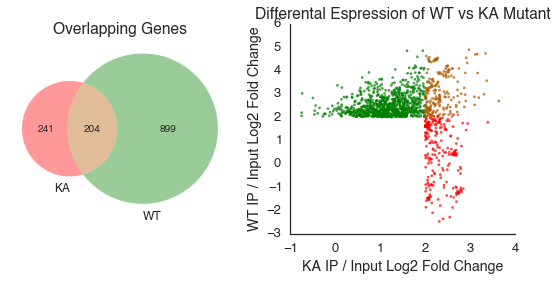

In [165]:
img_dir = "."

with dataviz.Figure(os.path.join(img_dir, "control_change.svg"), figsize=(8, 4)) as fig:
    ax = fig.add_subplot(1,2,1)
    venn = venn2((ka_df.index.get_level_values(level="gene_id"), wt_df.index.get_level_values(level="gene_id")),
         ax=ax,
         set_labels=("KA", "WT"))
    ax.set_title("Overlapping Genes")

    ax = fig.add_subplot(1,2,2)
    KA, WT, middle = [item.get_facecolor() for item in venn.patches]
    ka_genes = ka_df.index.get_level_values(level="gene_id")
    wt_genes = wt_df.index.get_level_values(level="gene_id")
    
    colors = []
    for gene in changing_in_either.columns:
        if gene in ka_genes and gene in wt_genes:
            colors.append(middle)
        elif gene in ka_genes:
            colors.append(KA)
        elif gene in wt_genes:
            colors.append(WT)
        
        
    ax.scatter(changing_in_either.ix['ka'].values, changing_in_either.ix['wt'].values, alpha=.7, color=colors, s=5)
    ax.set_xlabel("KA IP / Input Log2 Fold Change")
    ax.set_ylabel("WT IP / Input Log2 Fold Change")
    ax.set_title("Differental Espression of WT vs KA Mutant")
    sns.despine(ax=ax)

#Do Go analysis on uniquely changing genes

In [125]:
hg19go = GO.GO(GOFile="/projects/ps-yeolab/genomes/hg19/hg19.ENSG_to_GO.txt.gz")

MemoryError: 